In [1]:
# Numpy e Pandas per la manipolazione dei dati e il lavoro con i valori numerici
import numpy as np
import pandas as pd
import nltk

# Regex - Libreria di espressioni regolari 
import re

# NLTK - Natural Language Tool Kit - Utilizzato per l'elaborazione di dati testuali per l'analisi
from nltk.stem import WordNetLemmatizer

# Seaborn, Word Cloud e Matplotlib per la visualizzazione dei dati e il plottaggio dei grafici
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# SciKit Learn - Consiste in modelli Machine Learning 
from sklearn.svm import *
from sklearn.naive_bayes import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score


# Installazione e download NLTK
nltk.download('omw-1.4')

# Display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#Converte valore numerico in testo
def print_value(val):
    if val == 1: return "Positive"
    if val == -1: return "Negative"
    else: return "Neutral"

#Lettura del dataset (colonne User, Sentence, e Sentiment)
sentences = pd.read_excel("excel_results/sentences_vader.xlsx")[['User','Sentence','Sentiment']]

#sentences

<AxesSubplot: ylabel='Sentiment'>

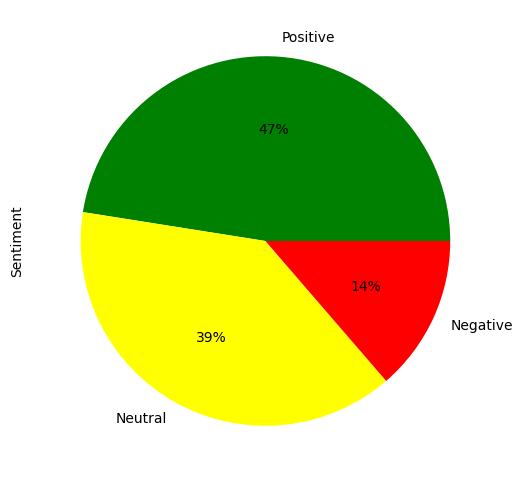

In [3]:
#Stampa grafico a torta generico dei valori di sentiment in generale sul dataset:

tmp = sentences['Sentiment'].apply(lambda x: print_value(x))
plot_size = plt.rcParams["figure.figsize"] 
#print(plot_size[0]) 
#print(plot_size[1])
plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

tmp.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["green", "yellow", "red"])

In [4]:
#VALUTAZIONE (è necessario rimuovere i valori NEUTRALI):
# Rimuoviamo i risultati NEUTRALI
sentences.drop(sentences[sentences.Sentiment == 0].index, inplace=True)
#sentences['Sentiment'] = sentences['Sentiment'].apply(lambda x: print_value(x))
sentences = sentences.reset_index(drop=True)


# Assegnazione dei valori per l'analisi
X=sentences['Sentence']
y=sentences['Sentiment']

# Definizione dei dati di training e di test (dati di test sono il 15%)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.15)


#Trasformazione del dataset con vettorizzazione TF-IDF:
# Vettorizzazione
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
vectoriser.fit(x_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))
# Trasformazione di vettori
x_train = vectoriser.transform(x_train)
x_test  = vectoriser.transform(x_test)

No. of feature_words:  65355


In [5]:
#Elenco dei modelli che vogliamo visualizzare sul grafico ROC
models = [
{
    'label': 'Bernoulli',
    'model': BernoulliNB(),
},
{
    'label': 'C-Support Vector',
    'model': SVC(probability=True),
},
{
    'label': 'multinomial Naive Bayes',
    'model': MultinomialNB(),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'K-Neighbors',
    'model': KNeighborsClassifier(),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}
]

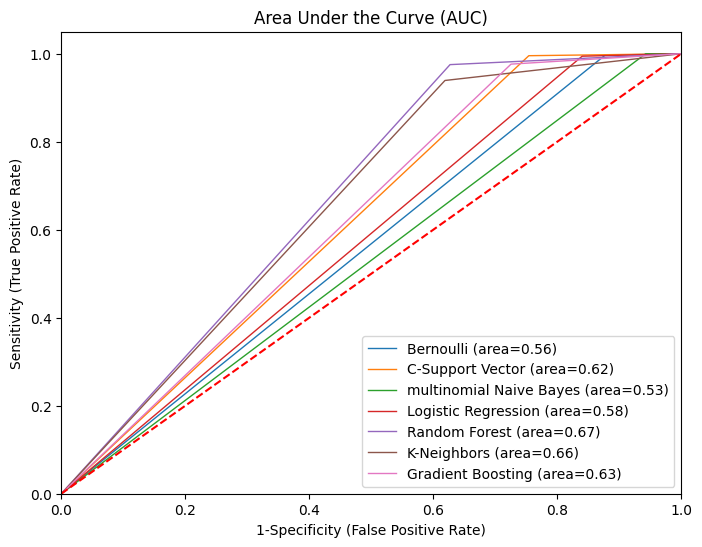

In [6]:
#GRAFICO DI CONFRONTO AUC-ROC

plt.figure()

#Per tutti i modelli:
for m in models:
    model = m['model']              # selezione del modello
    model.fit(x_train, y_train)     # addestramento
    y_pred=model.predict(x_test)    # predizione dei test data
    
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='%s (area=%0.2f)' % (m['label'], roc_auc))
    

    
# Impostazioni della grafico 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Area Under the Curve (AUC)')
plt.legend(loc="lower right")
plt.show()   

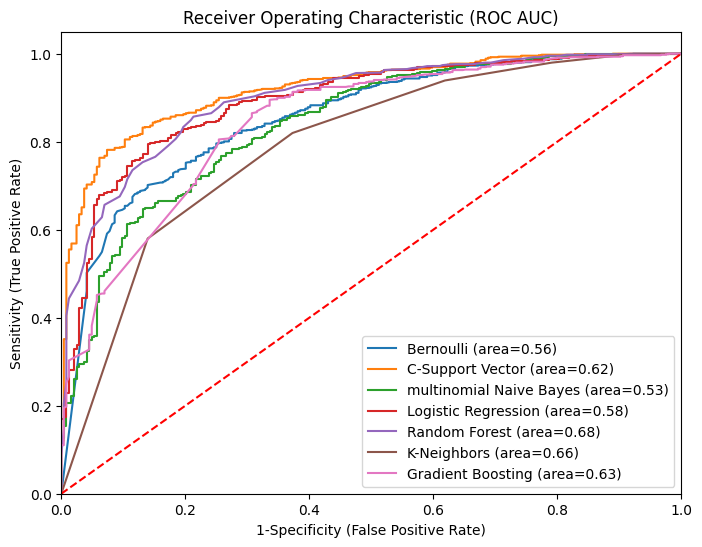

In [7]:
#GRAFICO DI CONFRONTO ROC

plt.figure()

#Per tutti i modelli:
for m in models:
    model = m['model']              # selezione del modello
    model.fit(x_train, y_train)     # addestramento
    y_pred=model.predict(x_test)    # predizione dei test data

    #Calcolo del tasso di falsi positivi e del tasso di veri positivi
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    #Calcolo dell'area della curva da visualizzare sul grafico
    auc_score = roc_auc_score(y_test,model.predict(x_test))
    #Tracciamento dei valori calcolati
    plt.plot(fpr, tpr, label='%s (area=%0.2f)' % (m['label'], auc_score))

# Impostazioni personalizzate per la tabella
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC AUC)')
plt.legend(loc="lower right")
plt.show()  

In [8]:
#stampa dei valori di classification_report
def print_classification_report(model):
    model_name = model['label']                # nome del modello
    model_classifier = model['model']          # selezione del modello
    model_classifier.fit(x_train, y_train)     # addestramento
    y_pred=model_classifier.predict(x_test)    # predizione dei test data

    df = pd.DataFrame(classification_report(y_test, y_pred, target_names=['NEGATIVE', 'POSITIVE'], output_dict=True)).transpose()
    #initialize figure
    fig = plt.figure(figsize = (8, .2))
    ax = fig.add_subplot(111)
    #create table
    ax.table(cellText = df.values, rowLabels = df.index, colLabels = df.columns, cellLoc='center')

    #add title to table
    ax.set_title(model_name, 
                fontdict={'fontsize': 20,
                            'fontweight': 'normal',
                            'color': 'steelblue'},
                loc='left')
    #turn axes off
    ax.axis('off')


# Stampa dei valori di confusion_matrix
def pritn_confusion_matrix(model):
    model_name = model['label']                # nome del modello
    model_classifier = model['model']          # selezione del modello
    model_classifier.fit(x_train, y_train)     # addestramento
    y_pred=model_classifier.predict(x_test)    # predizione dei test data

    # Matrice di confusione (Confusion Matrix)
    confusionmatrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    confmatrixplots = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    predictionsprecents = ['{0:.3%}'.format(value) for value in confusionmatrix.flatten() / np.sum(confusionmatrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(confmatrixplots,predictionsprecents)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusionmatrix, annot = labels, cmap = 'Pastel1',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':12}, labelpad = 20)
    plt.ylabel("Actual values" , fontdict = {'size':12}, labelpad = 20)
    plt.title (model_name+" Confusion Matrix", fontdict = {'size':14}, pad = 40)

    # Stampa
    plt.show()

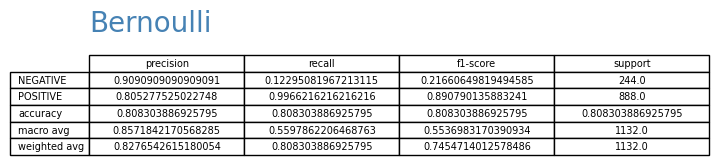

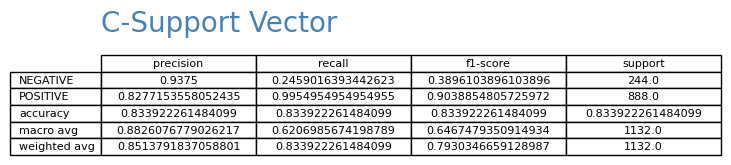

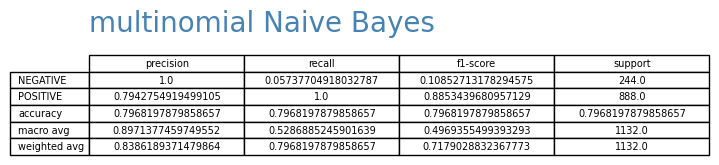

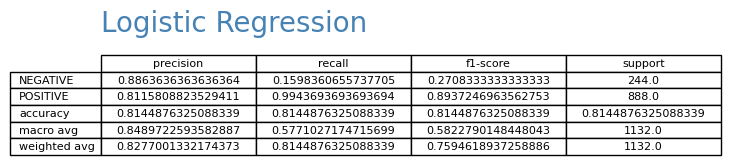

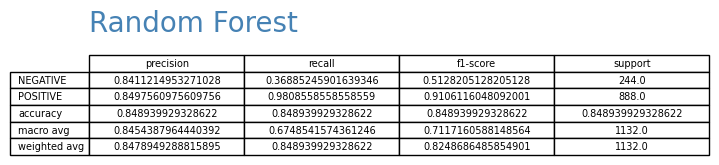

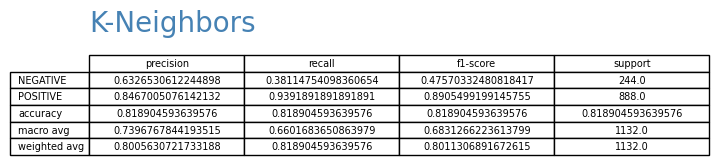

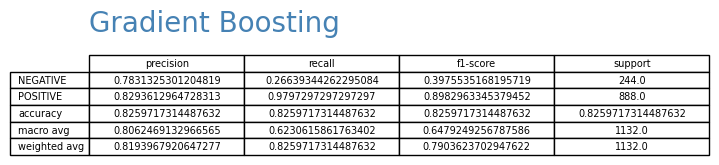

In [9]:
for m in models:
    print_classification_report(m)

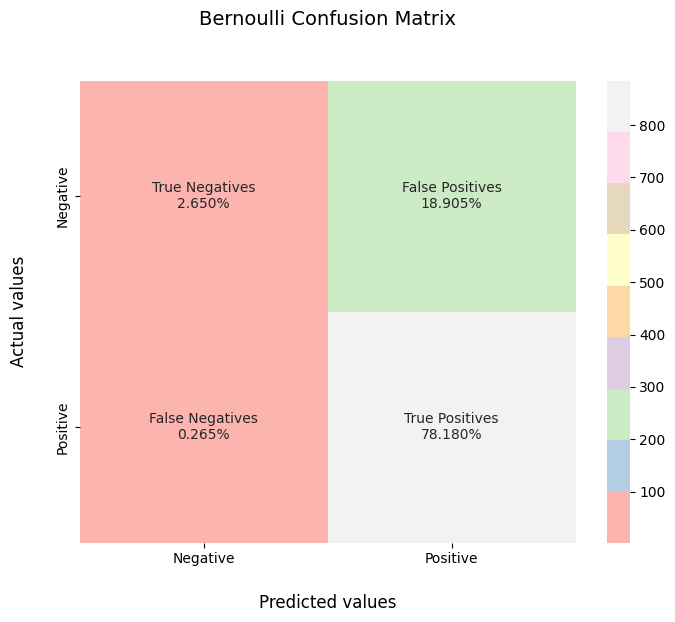

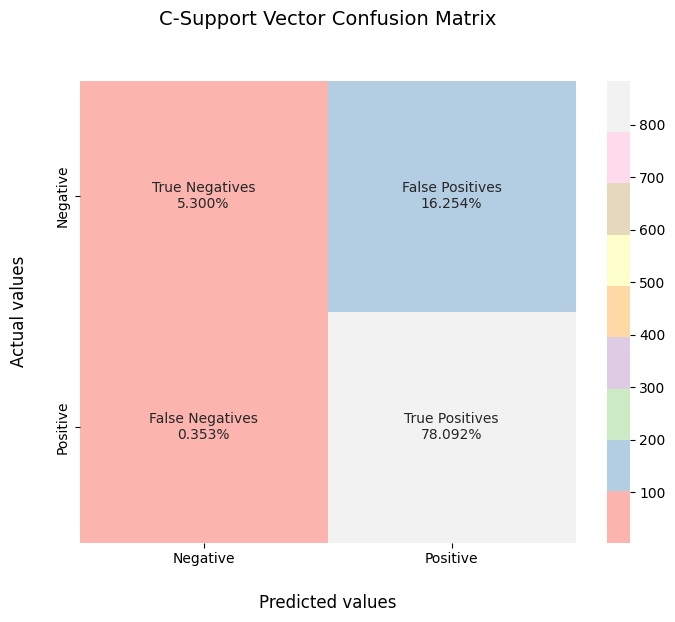

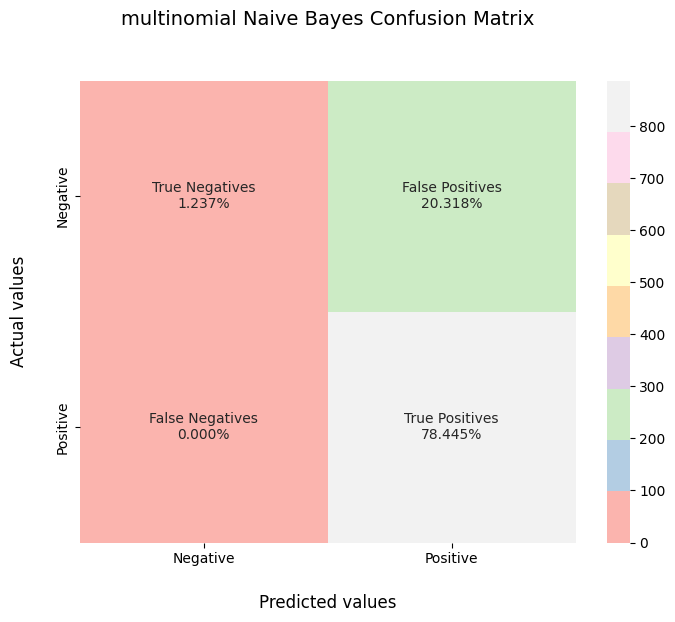

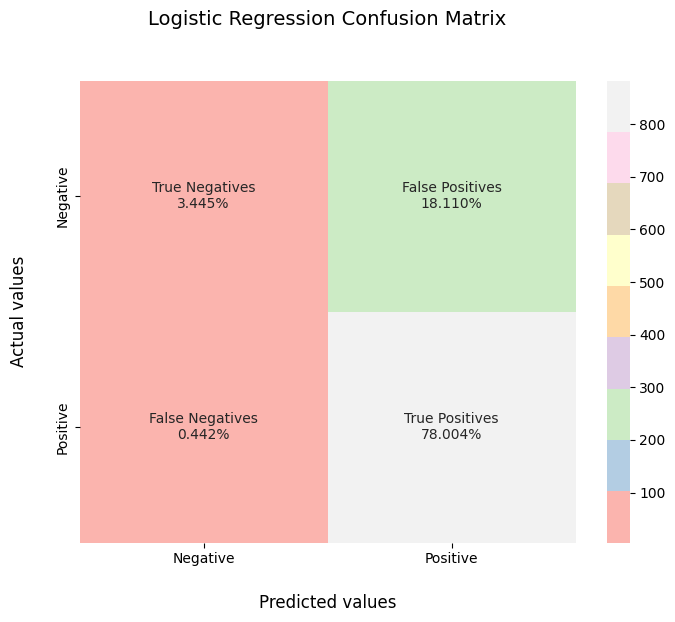

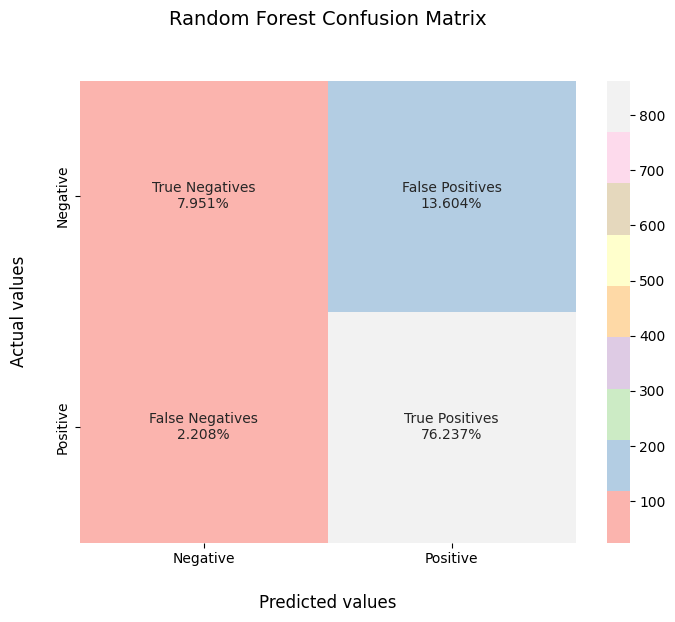

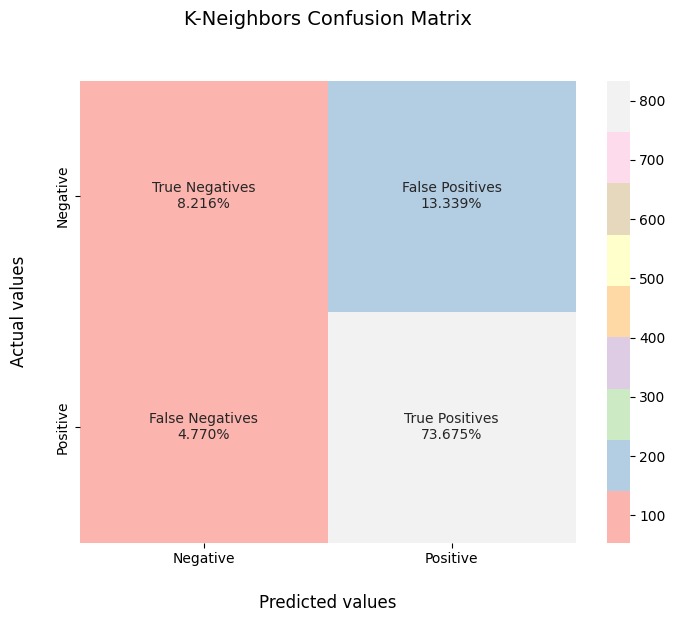

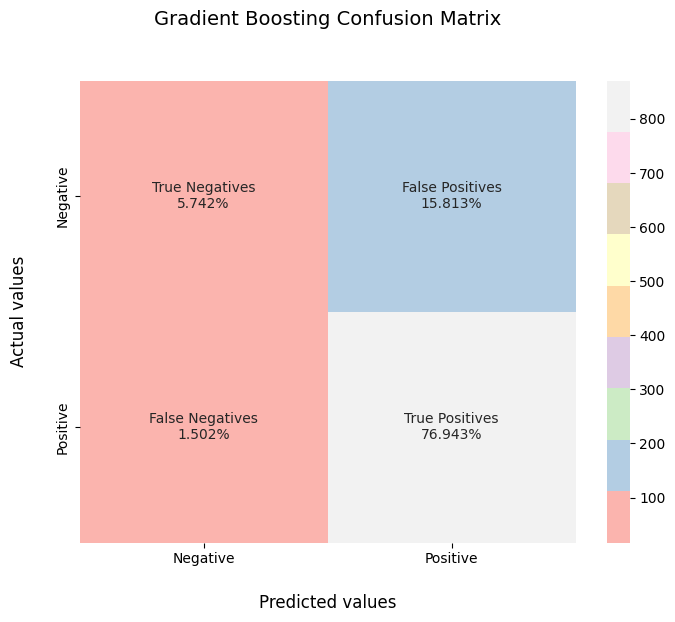

In [10]:
for m in models:
    pritn_confusion_matrix(m)